In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crypto-currency-bitcoin-and-ethereum-data/ETH-BTC-USD.csv


# 1. Importing necessary Libraries

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d00edc64d62f4bc5b26549df7db3cd5e05f669107da4330b38a12090933aab80
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# 2. Reading Data

In [4]:
df = pd.read_csv('/kaggle/input/crypto-currency-bitcoin-and-ethereum-data/ETH-BTC-USD.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Currency
0,11/14/2018,206.533997,207.044998,174.084000,181.397003,181.397003,2.595330e+09,Etherium
1,11/15/2018,181.899002,184.251007,170.188995,180.806000,180.806000,2.638410e+09,Etherium
2,11/16/2018,180.865005,181.350006,173.126007,175.177002,175.177002,2.015330e+09,Etherium
3,11/17/2018,175.360001,175.850998,172.869003,174.001007,174.001007,1.832800e+09,Etherium
4,11/18/2018,174.175003,179.151993,174.175003,177.067001,177.067001,1.810920e+09,Etherium


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Currency
3649,11/10/2023,36702.25000,37493.80078,36362.75391,37313.96875,37313.96875,2.271127e+10,Bitcoin
3650,11/11/2023,37310.07031,37407.09375,36773.66797,37138.05078,37138.05078,1.392427e+10,Bitcoin
3651,11/12/2023,37133.99219,37227.69141,36779.11719,37054.51953,37054.51953,1.154572e+10,Bitcoin
3652,11/13/2023,37070.30469,37405.11719,36399.60547,36502.35547,36502.35547,1.905771e+10,Bitcoin
3653,11/14/2023,36491.78906,36743.07031,36240.79688,36702.21484,36702.21484,1.838954e+10,Bitcoin


In [7]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Currency     0
dtype: int64

# 3. Exploratory Data Analysis (EDA)

#### 3.1 Visualizing the trends and patterns in the price data over time using line charts or candlestick charts.

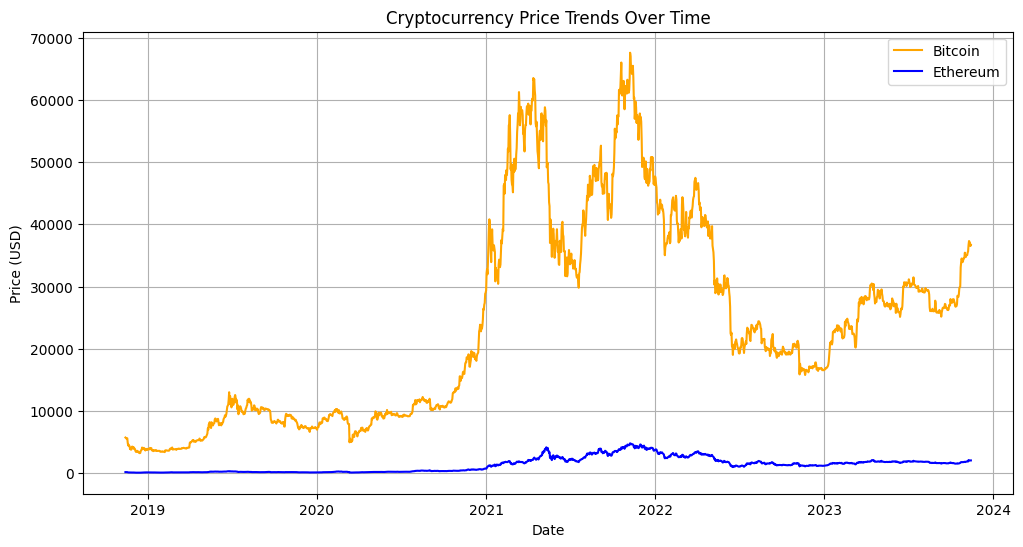

In [8]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Etherium']

# Find the common time range
common_dates = pd.merge(bitcoin_data['Date'], ethereum_data['Date'], how='inner', on='Date')

# Filter data to include only common dates
bitcoin_data_common = bitcoin_data[bitcoin_data['Date'].isin(common_dates['Date'])]
ethereum_data_common = ethereum_data[ethereum_data['Date'].isin(common_dates['Date'])]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data_common['Date'], bitcoin_data_common['Close'], label='Bitcoin', color='orange')
plt.plot(ethereum_data_common['Date'], ethereum_data_common['Close'], label='Ethereum', color='blue')
plt.title('Cryptocurrency Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Create a candlestick chart for Bitcoin
bitcoin_data = df[df['Currency'] == 'Bitcoin']
fig = go.Figure(data=[go.Candlestick(x=bitcoin_data['Date'],
                open=bitcoin_data['Open'],
                high=bitcoin_data['High'],
                low=bitcoin_data['Low'],
                close=bitcoin_data['Close'],
                name='Bitcoin')])

# Add a candlestick chart for Etherium (assuming 'Etherium' is the correct spelling in your dataset)
etherium_data = df[df['Currency'] == 'Etherium']
fig.add_trace(go.Candlestick(x=etherium_data['Date'],
                open=etherium_data['Open'],
                high=etherium_data['High'],
                low=etherium_data['Low'],
                close=etherium_data['Close'],
                name='Etherium'))

fig.update_layout(title='Cryptocurrency Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)')

fig.show()


#### 3.2 Exploring the distribution of trading volumes for both cryptocurrencies.

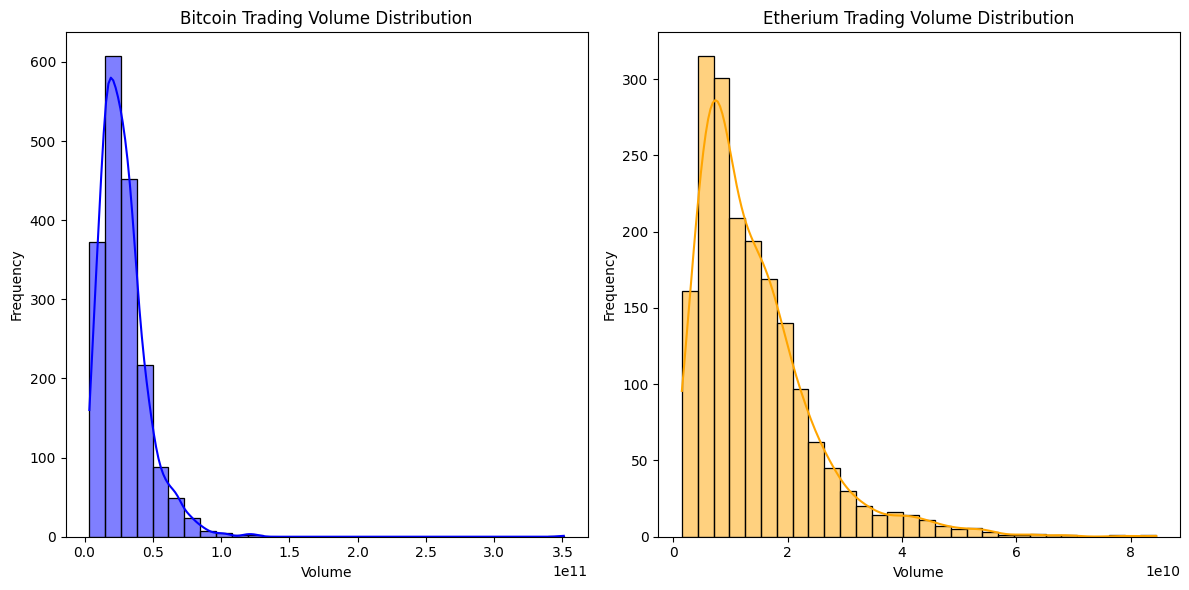

In [10]:
# Separate data for Bitcoin and Etherium
bitcoin_data = df[df['Currency'] == 'Bitcoin']
etherium_data = df[df['Currency'] == 'Etherium']

# Set up the figure with subplots
plt.figure(figsize=(12, 6))

# Plot histogram for Bitcoin trading volume
plt.subplot(1, 2, 1)
sns.histplot(bitcoin_data['Volume'], bins=30, kde=True, color='blue')
plt.title('Bitcoin Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Plot histogram for Etherium trading volume
plt.subplot(1, 2, 2)
sns.histplot(etherium_data['Volume'], bins=30, kde=True, color='orange')
plt.title('Etherium Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


#### 3.3 Looking for any outliers or anomalies in the data.

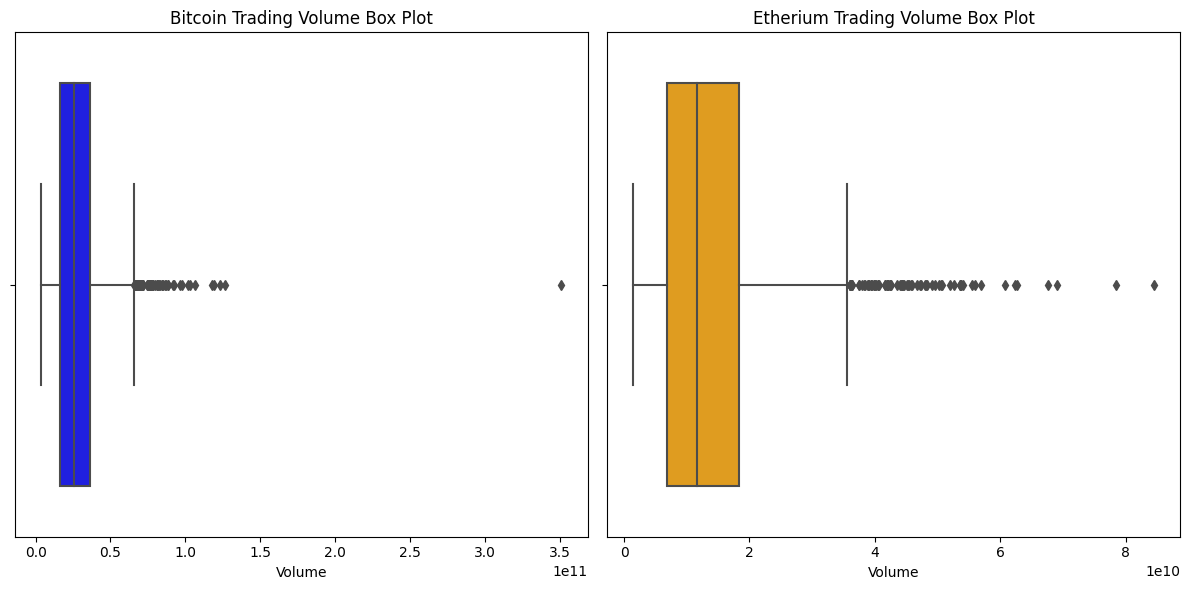

In [11]:
# Separate data for Bitcoin and Etherium
bitcoin_data = df[df['Currency'] == 'Bitcoin']
etherium_data = df[df['Currency'] == 'Etherium']

# Set up the figure with subplots
plt.figure(figsize=(12, 6))

# Box plot for Bitcoin trading volume
plt.subplot(1, 2, 1)
sns.boxplot(x=bitcoin_data['Volume'], color='blue')
plt.title('Bitcoin Trading Volume Box Plot')

# Box plot for Etherium trading volume
plt.subplot(1, 2, 2)
sns.boxplot(x=etherium_data['Volume'], color='orange')
plt.title('Etherium Trading Volume Box Plot')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
# Calculate IQR for Bitcoin trading volume
bitcoin_volume_iqr = bitcoin_data['Volume'].quantile(0.75) - bitcoin_data['Volume'].quantile(0.25)
bitcoin_volume_upper_bound = bitcoin_data['Volume'].quantile(0.75) + 1.5 * bitcoin_volume_iqr

# Identify outliers for Bitcoin
bitcoin_outliers = bitcoin_data[bitcoin_data['Volume'] > bitcoin_volume_upper_bound]

# Repeat the process for Etherium
etherium_volume_iqr = etherium_data['Volume'].quantile(0.75) - etherium_data['Volume'].quantile(0.25)
etherium_volume_upper_bound = etherium_data['Volume'].quantile(0.75) + 1.5 * etherium_volume_iqr

# Identify outliers for Etherium
etherium_outliers = etherium_data[etherium_data['Volume'] > etherium_volume_upper_bound]

# Print or further analyze the identified outliers
print("Bitcoin Outliers:")
print(bitcoin_outliers)

print("\nEtherium Outliers:")
print(etherium_outliers)


Bitcoin Outliers:
           Date          Open          High           Low         Close  \
2312 2020-03-13   5017.831055   5838.114746   4106.980957   5563.707031   
2360 2020-04-30   8797.669922   9440.650391   8533.255859   8658.553711   
2517 2020-10-04  10550.440430  10686.000000  10534.391600  10669.583010   
2591 2020-12-17  21308.351560  23642.660160  21234.675780  22805.162110   
2601 2020-12-27  26439.373050  28288.839840  25922.769530  26272.294920   
...         ...           ...           ...           ...           ...   
3102 2022-05-12  28936.734380  30032.439450  26350.490230  29047.751950   
3134 2022-06-13  26737.578130  26795.589840  22141.257810  22487.388670   
3282 2022-11-08  20600.671880  20664.607420  17603.544920  18541.271480   
3283 2022-11-09  18543.761720  18590.458980  15682.692380  15880.780270   
3284 2022-11-10  15883.158200  18054.312500  15834.018560  17586.771480   

         Adj Close        Volume Currency  
2312   5563.707031  7.415677e+10  Bit

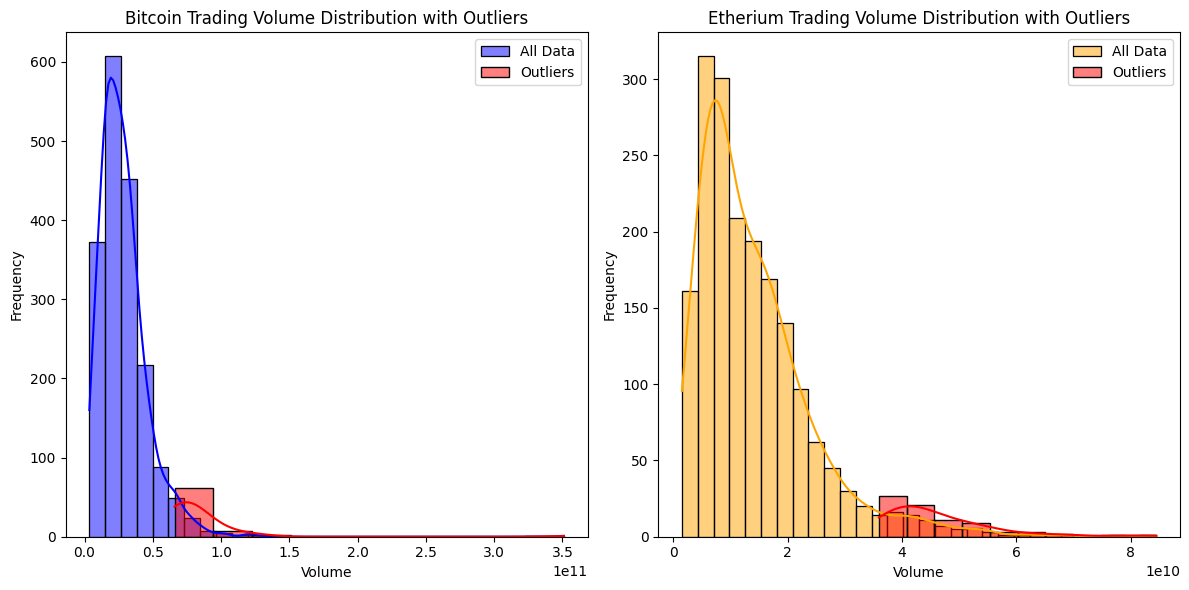

In [13]:
# Plot histograms for Bitcoin and Etherium volumes, highlighting outliers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(bitcoin_data['Volume'], bins=30, kde=True, color='blue', label='All Data')
sns.histplot(bitcoin_outliers['Volume'], bins=10, kde=True, color='red', label='Outliers')
plt.title('Bitcoin Trading Volume Distribution with Outliers')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(etherium_data['Volume'], bins=30, kde=True, color='orange', label='All Data')
sns.histplot(etherium_outliers['Volume'], bins=10, kde=True, color='red', label='Outliers')
plt.title('Etherium Trading Volume Distribution with Outliers')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# 4. Correlation Analysis

#### 4.1 Examining the correlation between the prices of Bitcoin and Ethereum.

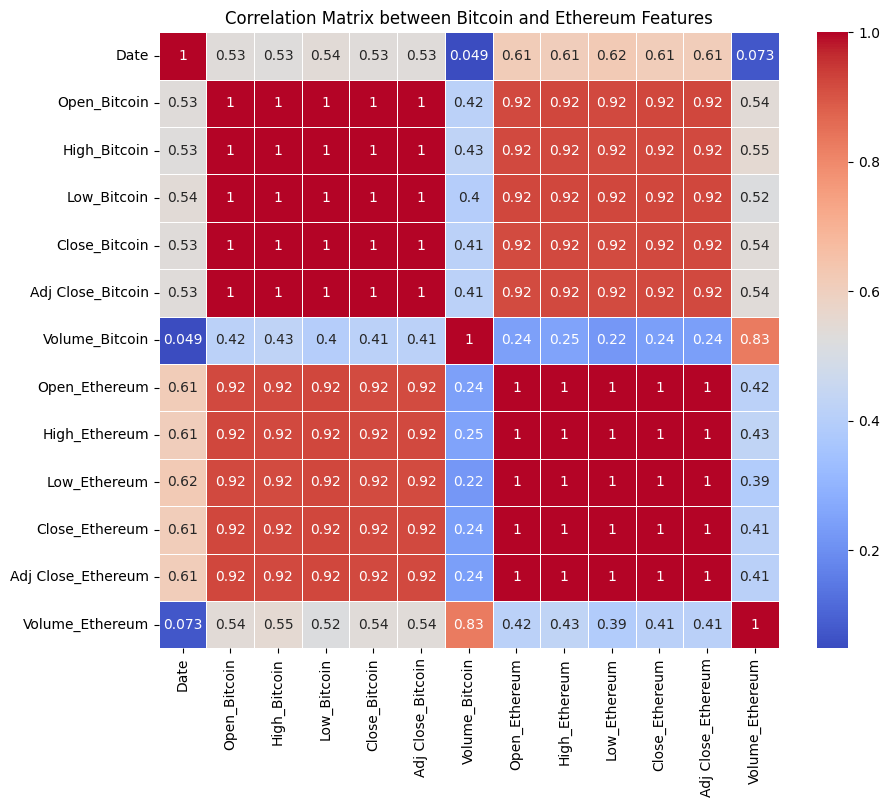

In [14]:
# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Etherium']  # Adjust the spelling as needed

# Select numeric columns excluding 'Currency'
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Merge the two datasets on the 'Date' column, excluding 'Currency'
merged_data = pd.merge(bitcoin_data[['Date'] + numeric_columns], ethereum_data[['Date'] + numeric_columns], on='Date', suffixes=('_Bitcoin', '_Ethereum'))

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix between Bitcoin and Ethereum Features')
plt.show()


# 5. Volatility Analysis

#### 5.1 Calculating and visualizing the volatility of Bitcoin and Ethereum prices. 

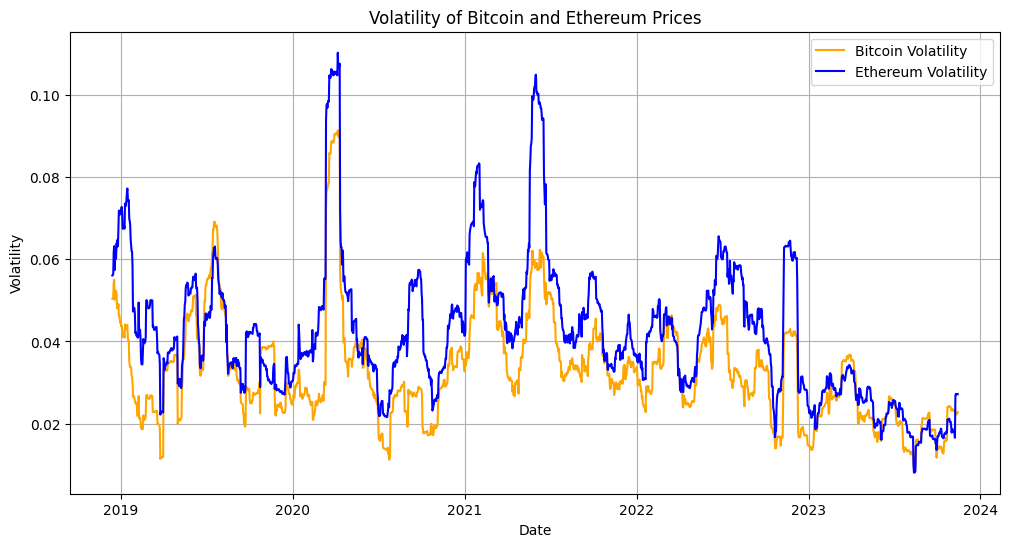

In [15]:
# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Etherium']  # Adjust the spelling as needed

# Calculate daily returns for Bitcoin and Ethereum
bitcoin_data['Daily_Return'] = bitcoin_data['Close'].pct_change()
ethereum_data['Daily_Return'] = ethereum_data['Close'].pct_change()

# Calculate the rolling standard deviation (volatility) for a specified window
window_size = 30  # You can adjust this value based on your preference
bitcoin_volatility = bitcoin_data['Daily_Return'].rolling(window=window_size).std()
ethereum_volatility = ethereum_data['Daily_Return'].rolling(window=window_size).std()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data['Date'], bitcoin_volatility, label='Bitcoin Volatility', color='orange')
plt.plot(ethereum_data['Date'], ethereum_volatility, label='Ethereum Volatility', color='blue')
plt.title('Volatility of Bitcoin and Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


# 6. Moving Averages

#### 6.1 Appling moving average techniques (e.g., simple moving averages or exponential moving averages) to smooth out price trends

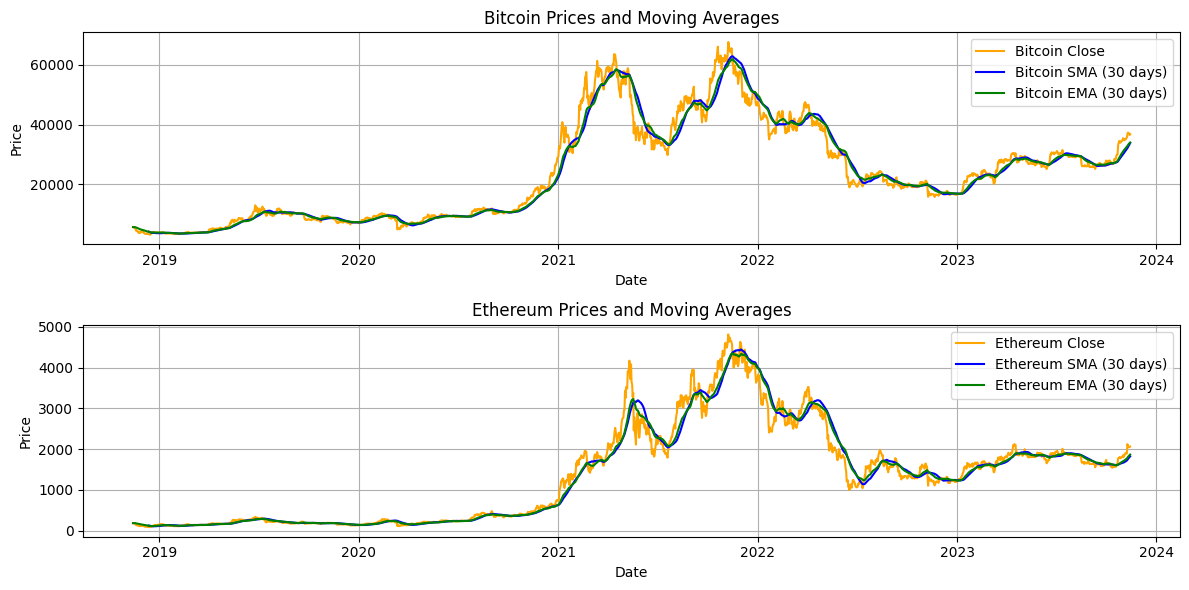

In [16]:
# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Etherium']  # Adjust the spelling as needed

# Calculate the simple moving averages (SMA)
sma_window = 30  # Adjust the window size based on your preference
bitcoin_data['SMA'] = bitcoin_data['Close'].rolling(window=sma_window).mean()
ethereum_data['SMA'] = ethereum_data['Close'].rolling(window=sma_window).mean()

# Calculate the exponential moving averages (EMA)
ema_window = 30  # Adjust the window size based on your preference
bitcoin_data['EMA'] = bitcoin_data['Close'].ewm(span=ema_window, adjust=False).mean()
ethereum_data['EMA'] = ethereum_data['Close'].ewm(span=ema_window, adjust=False).mean()

# Plotting
plt.figure(figsize=(12, 6))

# Plot Bitcoin prices and moving averages
plt.subplot(2, 1, 1)
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Bitcoin Close', color='orange')
plt.plot(bitcoin_data['Date'], bitcoin_data['SMA'], label=f'Bitcoin SMA ({sma_window} days)', color='blue')
plt.plot(bitcoin_data['Date'], bitcoin_data['EMA'], label=f'Bitcoin EMA ({ema_window} days)', color='green')
plt.title('Bitcoin Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot Ethereum prices and moving averages
plt.subplot(2, 1, 2)
plt.plot(ethereum_data['Date'], ethereum_data['Close'], label='Ethereum Close', color='orange')
plt.plot(ethereum_data['Date'], ethereum_data['SMA'], label=f'Ethereum SMA ({sma_window} days)', color='blue')
plt.plot(ethereum_data['Date'], ethereum_data['EMA'], label=f'Ethereum EMA ({ema_window} days)', color='green')
plt.title('Ethereum Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 7. Seasonal Trends:

#### 7.1 Checking for any seasonal trends or patterns in the cryptocurrency prices.

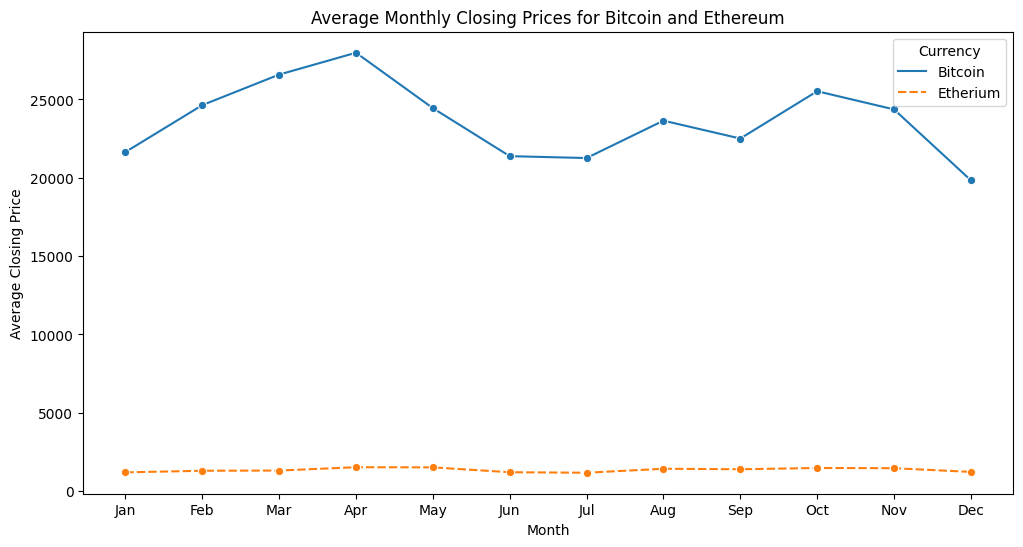

In [17]:
# Extract month and year from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Group by month and calculate the average closing price
average_monthly_prices = df.groupby(['Month', 'Currency'])['Close'].mean().reset_index()

# Pivot the table for better visualization
pivot_table = average_monthly_prices.pivot(index='Month', columns='Currency', values='Close')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_table, marker='o')
plt.title('Average Monthly Closing Prices for Bitcoin and Ethereum')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Currency')
plt.show()


# 8. Technical Analysis

#### 8.1 Utilizing technical indicators like Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), or Bollinger Bands to identify potential buy or sell signals.

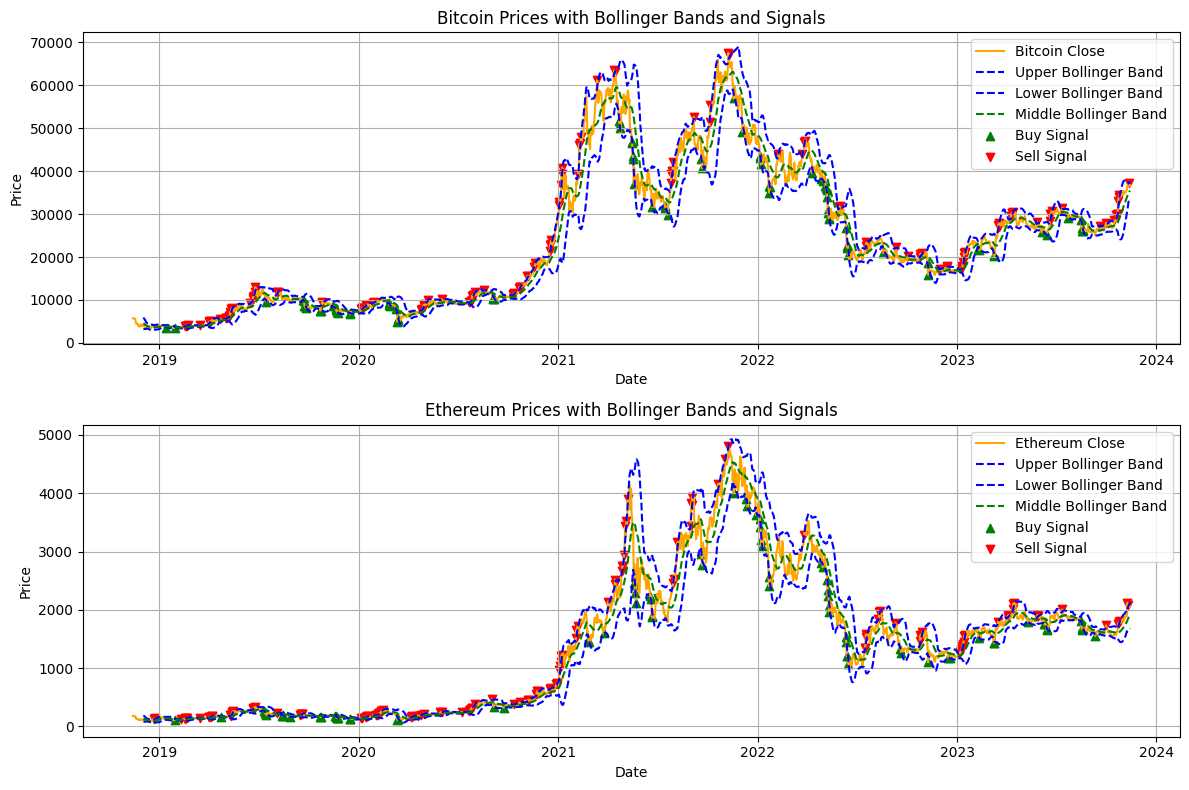

In [18]:
# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Etherium']  # Adjust the spelling as needed

# Initialize technical indicators
# MACD
bitcoin_data['macd'] = MACD(bitcoin_data['Close']).macd()
ethereum_data['macd'] = MACD(ethereum_data['Close']).macd()

# RSI
bitcoin_data['rsi'] = RSIIndicator(bitcoin_data['Close']).rsi()
ethereum_data['rsi'] = RSIIndicator(ethereum_data['Close']).rsi()

# Bollinger Bands
bb_bands_bitcoin = BollingerBands(bitcoin_data['Close'])
bitcoin_data['bb_upper'] = bb_bands_bitcoin.bollinger_hband()
bitcoin_data['bb_lower'] = bb_bands_bitcoin.bollinger_lband()
bitcoin_data['bb_mid'] = bb_bands_bitcoin.bollinger_mavg()

bb_bands_ethereum = BollingerBands(ethereum_data['Close'])
ethereum_data['bb_upper'] = bb_bands_ethereum.bollinger_hband()
ethereum_data['bb_lower'] = bb_bands_ethereum.bollinger_lband()
ethereum_data['bb_mid'] = bb_bands_ethereum.bollinger_mavg()

# Identify buy and sell signals based on Bollinger Bands
bitcoin_data['Buy_Signal'] = (bitcoin_data['Close'] < bitcoin_data['bb_lower']).astype(int)
bitcoin_data['Sell_Signal'] = (bitcoin_data['Close'] > bitcoin_data['bb_upper']).astype(int)

ethereum_data['Buy_Signal'] = (ethereum_data['Close'] < ethereum_data['bb_lower']).astype(int)
ethereum_data['Sell_Signal'] = (ethereum_data['Close'] > ethereum_data['bb_upper']).astype(int)

# Plotting
plt.figure(figsize=(12, 8))

# Plot Bitcoin prices and technical indicators with signals
plt.subplot(2, 1, 1)
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Bitcoin Close', color='orange')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_upper'], label='Upper Bollinger Band', linestyle='--', color='blue')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_lower'], label='Lower Bollinger Band', linestyle='--', color='blue')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_mid'], label='Middle Bollinger Band', linestyle='--', color='green')
plt.scatter(bitcoin_data['Date'][bitcoin_data['Buy_Signal'] == 1], bitcoin_data['Close'][bitcoin_data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(bitcoin_data['Date'][bitcoin_data['Sell_Signal'] == 1], bitcoin_data['Close'][bitcoin_data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red')
plt.title('Bitcoin Prices with Bollinger Bands and Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot Ethereum prices and technical indicators with signals
plt.subplot(2, 1, 2)
plt.plot(ethereum_data['Date'], ethereum_data['Close'], label='Ethereum Close', color='orange')
plt.plot(ethereum_data['Date'], ethereum_data['bb_upper'], label='Upper Bollinger Band', linestyle='--', color='blue')
plt.plot(ethereum_data['Date'], ethereum_data['bb_lower'], label='Lower Bollinger Band', linestyle='--', color='blue')
plt.plot(ethereum_data['Date'], ethereum_data['bb_mid'], label='Middle Bollinger Band', linestyle='--', color='green')
plt.scatter(ethereum_data['Date'][ethereum_data['Buy_Signal'] == 1], ethereum_data['Close'][ethereum_data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(ethereum_data['Date'][ethereum_data['Sell_Signal'] == 1], ethereum_data['Close'][ethereum_data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red')
plt.title('Ethereum Prices with Bollinger Bands and Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 9. Prediction Models

#### 9.1 ARIMA

Mean Squared Error: 119615779.24696702


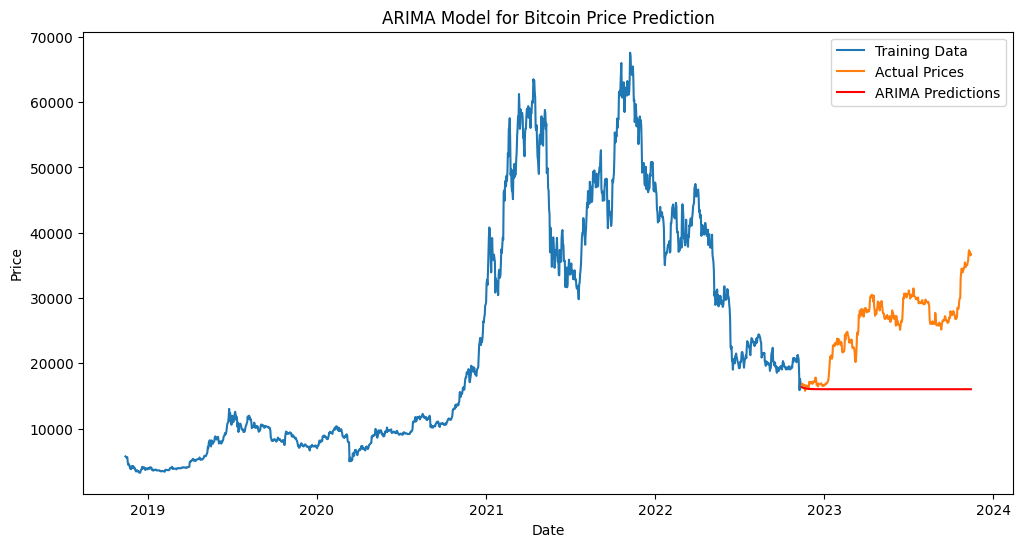

In [19]:
# Select relevant columns and set 'Date' as the index
bitcoin_data = df[df['Currency'] == 'Bitcoin'][['Date', 'Close']].set_index('Date')

# Split the data into training and testing sets
train_size = int(len(bitcoin_data) * 0.8)
train, test = bitcoin_data.iloc[:train_size], bitcoin_data.iloc[train_size:]

# Train the ARIMA model
model = ARIMA(train, order=(5, 1, 2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model for Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#### 9.2 LSTM

Epoch 1/100
46/46 - 2s - loss: 0.1128 - 2s/epoch - 37ms/step
Epoch 2/100
46/46 - 0s - loss: 0.0071 - 84ms/epoch - 2ms/step
Epoch 3/100
46/46 - 0s - loss: 0.0015 - 92ms/epoch - 2ms/step
Epoch 4/100
46/46 - 0s - loss: 0.0013 - 86ms/epoch - 2ms/step
Epoch 5/100
46/46 - 0s - loss: 0.0013 - 88ms/epoch - 2ms/step
Epoch 6/100
46/46 - 0s - loss: 0.0012 - 85ms/epoch - 2ms/step
Epoch 7/100
46/46 - 0s - loss: 0.0011 - 85ms/epoch - 2ms/step
Epoch 8/100
46/46 - 0s - loss: 0.0011 - 84ms/epoch - 2ms/step
Epoch 9/100
46/46 - 0s - loss: 0.0011 - 84ms/epoch - 2ms/step
Epoch 10/100
46/46 - 0s - loss: 0.0010 - 82ms/epoch - 2ms/step
Epoch 11/100
46/46 - 0s - loss: 9.7995e-04 - 84ms/epoch - 2ms/step
Epoch 12/100
46/46 - 0s - loss: 9.4334e-04 - 87ms/epoch - 2ms/step
Epoch 13/100
46/46 - 0s - loss: 8.8931e-04 - 87ms/epoch - 2ms/step
Epoch 14/100
46/46 - 0s - loss: 8.5279e-04 - 81ms/epoch - 2ms/step
Epoch 15/100
46/46 - 0s - loss: 8.0961e-04 - 86ms/epoch - 2ms/step
Epoch 16/100
46/46 - 0s - loss: 7.5986e-04 - 

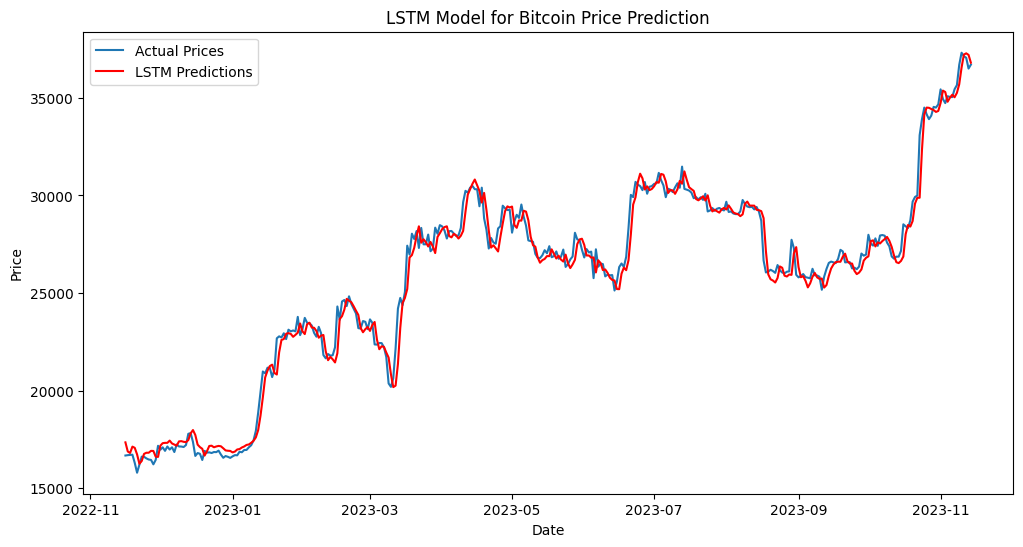

In [20]:
# Select relevant columns and set 'Date' as the index
bitcoin_data = df[df['Currency'] == 'Bitcoin'][['Date', 'Close']].set_index('Date')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data)

# Prepare the data for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 10  # Adjust as needed
X, y = create_dataset(scaled_data, time_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

# Reshape the input data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, time_steps), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

# Make predictions on the test set
predictions = model.predict(testX)
predictions = scaler.inverse_transform(predictions)

# Invert the scaling for the actual values
actual_values = scaler.inverse_transform([testY])

# Evaluate the model
mse = mean_squared_error(actual_values[0], predictions[:, 0])
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data.index[train_size+time_steps:], actual_values[0], label='Actual Prices')
plt.plot(bitcoin_data.index[train_size+time_steps:], predictions[:, 0], label='LSTM Predictions', color='red')
plt.title('LSTM Model for Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# 10. Conclusion

Thank you for accompanying me through this enlightening journey of exploratory data analysis (EDA). Even though I have only scratched the surface of the dataset's potential, I have gained the insights I sought. This exploration has bestowed upon me valuable knowledge and answered the questions that plagued my mind. While there are numerous other possible conclusions and analyses, I have decided to end my EDA here.

I trust that you found my notebook engaging and, more importantly, beneficial. I welcome any feedback you may have, and I assure you that I read and respond to each one with utmost sincerity. If you have enjoyed our conversation, an upvote would be greatly appreciated.

I wish you the best of luck in your endeavors!